<a href="https://colab.research.google.com/github/taras-musakovskyi/colab-jupyter-fish-models/blob/main/2_stage_manual_inpaint_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# todo - focus on cell 5 improvements, see thread in GPT
# ============================================================================
# CELL 1: Installation & Imports
# ============================================================================
!pip install diffusers==0.27.2 -q
!pip install transformers==4.41.0 -q
!pip install accelerate==0.27.2 -q
!pip install peft==0.8.2 -q
!pip install safetensors==0.4.2 -q
!pip install huggingface_hub==0.23.0 -q
# Skip xformers - not required, causing build issues

import torch
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline, EulerAncestralDiscreteScheduler
from peft import PeftModel
import json
import os
import shutil
from safetensors.torch import load_file

print(f"✓ Imports complete")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 25.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.23.0 which is incompatible.
datasets 4.0.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.23

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

✓ Imports complete
PyTorch: 2.8.0+cu126
CUDA available: True


In [ ]:

# ============================================================================
# CELL 2: Configuration
# ============================================================================
# Google Drive file IDs
UNDERWATER_LORA_FILE_ID = "1HUnJowwUH3FhMS2PYdzd45tVz_a_N2bp" #underwater_lora_best_epoch_35_20251011_215941
"1Lm69A3BN5ixhiFIz4bXYiNOc6CzK0ypt" #underwater_lora_best_epoch_43_20251009_212525
SPECIES_LORA_FILE_ID = "1raH1cOdNGIJZ5xMX925NbTHPuBuDXG7H"        # back_up_this_one_lora_1b_best_epoch_24_20251006_121339
APARTMENT_IMAGE_FILE_ID = "1nx752-K8bCk4wMsFdvC0aFy97f-F93ea"  # apartment.jpg

#REFERENCE_IMG3_FILE_ID = "1Lcj0PvujoiINMHD-hCq3hzB99L8Yrjnz"
#REFERENCE_IMG2_FILE_ID = "1-VTSIn-nAsX-PuQNBYQZjaTkvzdgiBh1"
#REFERENCE_IMG1_FILE_ID = "1B8m-f7tzerySJ-XeB41QRJb9SydnAChE"

# IP-Adapter settings
#IP_ADAPTER_SCALE = 0.5  # Style transfer strength

# Model settings
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
UNDERWATER_PROMPT = "modern apartment interior, submerged in clear blue water, caustic light patterns on walls, bubbles floating, volumetric lighting, refraction, underwater rays"
#"apartment filled with water, bubbles floating"
#"apartment filled with water#apartment filled with water#, bubbles floating"
#"modern apartment interior, submerged in clear blue water, caustic light patterns on walls, bubbles floating, volumetric lighting, refraction, underwater rays"
#"completely underwater, submerged room, filled with water, thick water atmosphere, underwater photography, aquatic environment"
#"underwater effects with blue lighting, caustics patterns on walls, water refraction effects, bubbles floating"
                    # underwater living room    with light caustics on walls, blue tinted lighting, bubbles floating
NEGATIVE_PROMPT = "blurry, distorted, low quality"

# LoRA settings (from your training config)
LORA_RANK = 32
LORA_ALPHA = 64
LORA_SCALE = 1.2
IMG2IMG_STRENGTH = 0.62

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Configuration set - Device: {device}")

✓ Configuration set - Device: cuda


In [ ]:
# ============================================================================
# CELL 3: Download Files from Google Drive
# ============================================================================
from google.colab import auth
from googleapiclient.discovery import build
import io

print("🔐 Authenticating with Google Drive...")
auth.authenticate_user()
from google.auth import default
creds, _ = default()
drive_service = build('drive', 'v3', credentials=creds)

def download_from_drive(file_id, output_path):
    """Download file from Google Drive"""
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    from googleapiclient.http import MediaIoBaseDownload
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
    fh.seek(0)
    with open(output_path, 'wb') as f:
        f.write(fh.read())
    print(f"✓ Downloaded {output_path}")

# Download files
print("\n📥 Downloading files...")
download_from_drive(UNDERWATER_LORA_FILE_ID, "underwater_lora.safetensors")
download_from_drive(APARTMENT_IMAGE_FILE_ID, "apartment.jpg")

#download_from_drive(REFERENCE_IMG1_FILE_ID, "reference1.jpg")
#download_from_drive(REFERENCE_IMG2_FILE_ID, "reference2.jpg")
#download_from_drive(REFERENCE_IMG3_FILE_ID, "reference3.jpg")

🔐 Authenticating with Google Drive...

📥 Downloading files...
✓ Downloaded underwater_lora.safetensors
✓ Downloaded apartment.jpg


In [ ]:
# ============================================================================
# CELL 4: Prepare LoRA in PEFT Format
# ============================================================================
print("\n📦 Preparing underwater LoRA in PEFT format...")

# Create directory for PEFT format
lora_dir = "/content/underwater_lora_peft"
os.makedirs(lora_dir, exist_ok=True)

# Copy safetensors file
shutil.copy("underwater_lora.safetensors", f"{lora_dir}/adapter_model.safetensors")

# Create adapter_config.json for PEFT
adapter_config = {
    "base_model_name_or_path": MODEL_NAME,
    "peft_type": "LORA",
    "task_type": "DIFFUSION_IMAGE_GENERATION",
    "r": LORA_RANK,
    "lora_alpha": LORA_ALPHA,
    "lora_dropout": 0.05,
    "target_modules": ["to_k", "to_q", "to_v", "to_out.0"],
    "inference_mode": True
}

with open(f"{lora_dir}/adapter_config.json", "w") as f:
    json.dump(adapter_config, f, indent=2)

print("✓ LoRA prepared in PEFT format")


📦 Preparing underwater LoRA in PEFT format...
✓ LoRA prepared in PEFT format


In [ ]:
# ============================================================================
# CELL 5: Load Pipeline and Apply LoRA
# ============================================================================
print("\n🌊 Loading img2img pipeline...")

# Load base pipeline
import transformers
transformers.modeling_utils.offload_state_dict = False

# Then load pipeline
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None,
    requires_safety_checker=False
)

# Use faster scheduler
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

print("✓ Base pipeline loaded")

# Load LoRA weights onto UNet
print("\n📦 Loading underwater LoRA onto UNet...")
#pipeline.unet = PeftModel.from_pretrained(
#    pipeline.unet,
#    lora_dir,
#    adapter_name="underwater"
#)

# Set adapter with scale
#pipeline.unet.set_adapter("underwater")

try:
    pipeline.unet.load_attn_procs("underwater_lora.safetensors")
    print("✓ loaded underwater_lora into unet.attn_processors")
except Exception as e:
    print("⚠ failed to load_attn_procs:", e)

# apply LORA_SCALE to processors if available
for name, proc in getattr(pipeline.unet, "attn_processors", {}).items():
    if hasattr(proc, "lora_scale"):
        proc.lora_scale = LORA_SCALE
    elif hasattr(proc, "scale"):
        proc.scale = LORA_SCALE

# move pipeline to device if not already
pipeline = pipeline.to(device)

print("✓ Underwater LoRA loaded and configured")

# Move to device and enable memory efficient attention
pipeline = pipeline.to(device)

#if device == "cuda":
#    pipeline.enable_xformers_memory_efficient_attention()
#    print("✓ XFormers enabled")



🌊 Loading img2img pipeline...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✓ Base pipeline loaded

📦 Loading underwater LoRA onto UNet...
✓ loaded underwater_lora into unet.attn_processors
✓ Underwater LoRA loaded and configured


In [ ]:
# Cell 5.5 - Complete with install
#!pip install git+https://github.com/tencent-ailab/IP-Adapter.git -q

#from diffusers import StableDiffusionImg2ImgPipeline
#from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

#print("\n🎨 Loading IP-Adapter...")

# Load IP-Adapter weights
#pipeline.load_ip_adapter(
#    "h94/IP-Adapter",
#    subfolder="models",
#    weight_name="ip-adapter_sd15.bin"
#)

# Load reference images
#ref_images = [
#    Image.open("reference1.jpg").convert("RGB"),
#    Image.open("reference2.jpg").convert("RGB"),
#    Image.open("reference3.jpg").convert("RGB")
#]

# Set IP-Adapter scale
#pipeline.set_ip_adapter_scale(IP_ADAPTER_SCALE)

#print(f"✓ IP-Adapter configured with {len(ref_images)} references")

In [ ]:
# ============================================================================
# CELL 6: Verify LoRA Application
# ============================================================================
print("\n🔍 Verifying LoRA application...")

# Check if LoRA is loaded
def verify_lora(unet):
    has_lora = False
    lora_modules = []

    for name, module in unet.named_modules():
        if hasattr(module, 'lora_A') or hasattr(module, 'lora_B'):
            has_lora = True
            lora_modules.append(name)

    if has_lora:
        print(f"✓ LoRA detected in UNet")
        print(f"  Found {len(lora_modules)} LoRA modules")
        print(f"  Sample modules: {lora_modules[:3]}")
    else:
        print("⚠️ No LoRA modules found!")

    return has_lora

verify_lora(pipeline.unet)


🔍 Verifying LoRA application...
⚠️ No LoRA modules found!


False

In [ ]:
# ============================================================================
# CELL 7: Apply Underwater Effects
# ============================================================================
print("\n🎨 Generating underwater apartment...")

# Load apartment image
apartment_img = Image.open("apartment.jpg").convert("RGB")
print(f"✓ Image loaded: {apartment_img.size}")

# Generate underwater version
print(f"Prompt: {UNDERWATER_PROMPT[:60]}...")
print(f"Strength: {IMG2IMG_STRENGTH}")

print("\n🎨 Generating...")

# Generate with IP-Adapter
#underwater_result = pipeline(
#    prompt=UNDERWATER_PROMPT,
##    negative_prompt=NEGATIVE_PROMPT,
#    image=apartment_img,
#    #ip_adapter_image=ref_images[0],  # Just first reference
#    strength=IMG2IMG_STRENGTH,
#    num_inference_steps=30,
#    guidance_scale=7.0
#).images[0]

underwater_result = pipeline(
    prompt=UNDERWATER_PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    image=apartment_img,
    strength=IMG2IMG_STRENGTH,
    num_inference_steps=50,
    guidance_scale=9.5
).images[0]

#print(f"✓ Generated with IP-Adapter scale: {IP_ADAPTER_SCALE}")
print("✓ Underwater effects applied")


🎨 Generating underwater apartment...
✓ Image loaded: (4032, 3024)
Prompt: modern apartment interior, submerged in clear blue water, ca...
Strength: 0.62

🎨 Generating...


  0%|          | 0/31 [00:00<?, ?it/s]

✓ Underwater effects applied


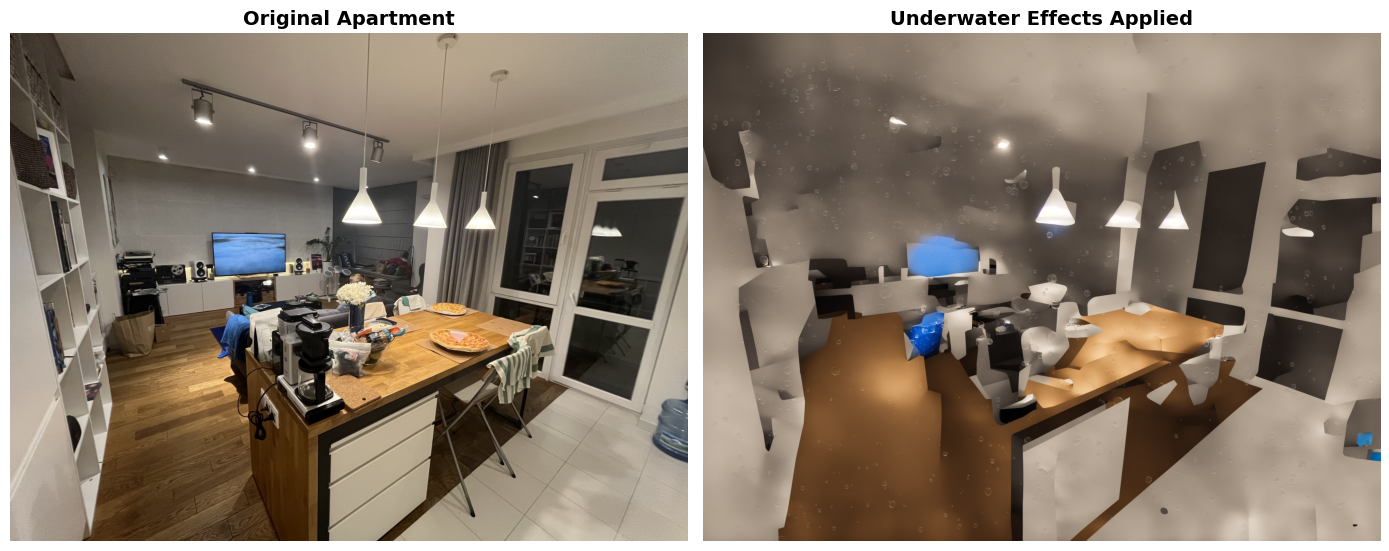


✅ Stage 1 complete! Saved as 'underwater_apartment.png'

Settings used:
  LoRA scale: 1.2
  Img2img strength: 0.62
  Model: runwayml/stable-diffusion-v1-5


In [ ]:
# ============================================================================
# CELL 8: Display Results
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(apartment_img)
axes[0].set_title("Original Apartment", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(underwater_result)
axes[1].set_title("Underwater Effects Applied", fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Save result
underwater_result.save("underwater_apartment.png")
print("\n✅ Stage 1 complete! Saved as 'underwater_apartment.png'")
print(f"\nSettings used:")
print(f"  LoRA scale: {LORA_SCALE}")
print(f"  Img2img strength: {IMG2IMG_STRENGTH}")
print(f"  Model: {MODEL_NAME}")